In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from numpy import mean, std
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
import pre as pr

In [6]:
from pre import X_train, X_test, df, y_train, y_test

In [13]:
def RandomForest_trainer():
    n= 100
    md= 20
    split= 5
    leaf= 2
    state= 42
    njobs= -1
    rf_model = RandomForestClassifier(
    n_estimators=n,
    max_depth=md,
    min_samples_split= split,
    min_samples_leaf= leaf,
    random_state= state,
    n_jobs=njobs
)
    rf_model.fit(X_train,y_train)
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:,1]
    print("\n" + "="*60)
    print("RESULTADOS DEL MODELO")
    print("="*60)
    print(f"\n Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    return confusion_matrix(y_test, y_pred)


In [14]:
RandomForest_trainer()


RESULTADOS DEL MODELO

 Accuracy: 0.8167

 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      1364
           1       0.78      0.89      0.83      1364

    accuracy                           0.82      2728
   macro avg       0.82      0.82      0.82      2728
weighted avg       0.82      0.82      0.82      2728


Confusion Matrix:


array([[1017,  347],
       [ 153, 1211]])

In [ ]:
def classification_report(y_test, y_pred, positive_label=1):
    tp = 0
    fn= 0
    fp = 0
    tn = 0
    for i, j in zip(y_test, y_pred):
        if i == positive_label:
            if j == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if j == positive_label:
                fp += 1
            else:
                tn += 1
    return tp, fn, fp, tn

def accuracy(tp, fn, fp, tn):
    return (tp + tn) / (tp + fn + fp + tn)

def precision(tp, fn, fp, tn):
    return tp / (tp + fp)

def recall(tp, fn, fp, tn):
    return tp / (tp + fn)

def f1_score(tp, fn, fp, tn):
    Precision = precision(tp, fn, fp, tn)
    Recall = recall(tp, fn, fp, tn)
    F1_score = 2 * (Precision * Recall) / (Precision + Recall)
    return F1_score

def sensitivity(tp, fn, fp, tn):
    Sensitivity = tp / (tp + fn)
    return Sensitivity

def specificity(tp, fn, fp, tn):
    Specificity = tn / (tn + fp)
    return Specificity


In [ ]:
start_time = time.time()

In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.89217759 0.86046512 0.86469345 0.86257928 0.85623679 0.87076271
 0.87076271 0.88135593 0.88983051 0.89830508 0.86680761 0.88794926
 0.86046512 0.87315011 0.85412262 0.87288136 0.90042373 0.87711864
 0.88135593 0.86440678 0.86469345 0.86680761 0.86892178 0.84566596
 0.88794926 0.86864407 0.89618644 0.87923729 0.87711864 0.86864407
 0.84566596 0.87315011 0.87526427 0.90063425 0.87737844 0.875
 0.8940678  0.875      0.88771186 0.86440678 0.8794926  0.90274841
 0.87737844 0.89006342 0.88372093 0.84957627 0.88347458 0.88347458
 0.86228814 0.84322034]
Accuracy: 0.8747 (0.0146)


In [ ]:


# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('sensitivity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))



[0.84343434 0.83333333 0.83333333 0.85858586 0.80808081 0.83756345
 0.83838384 0.83838384 0.82828283 0.88383838 0.82323232 0.83333333
 0.80808081 0.83838384 0.81313131 0.8071066  0.87373737 0.88888889
 0.85353535 0.80808081 0.82828283 0.81818182 0.85858586 0.84848485
 0.83333333 0.83248731 0.87878788 0.84343434 0.81313131 0.83333333
 0.84343434 0.84848485 0.82828283 0.87878788 0.82323232 0.83248731
 0.86363636 0.81818182 0.82828283 0.81818182 0.82323232 0.89393939
 0.84848485 0.83333333 0.83333333 0.83756345 0.83838384 0.86868687
 0.87373737 0.76262626]
sensitivity: 0.8387 (0.0244)


In [ ]:
specificity = make_scorer(recall_score, pos_label=0)

In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, cv=cv, scoring = specificity, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('specificity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.94181818 0.88727273 0.88       0.90545455 0.90545455 0.89454545
 0.88686131 0.93430657 0.91970803 0.88321168 0.88727273 0.91636364
 0.88363636 0.88727273 0.87636364 0.93090909 0.91605839 0.88321168
 0.88686131 0.92335766 0.90909091 0.89090909 0.88       0.85454545
 0.93454545 0.89090909 0.91240876 0.91240876 0.9379562  0.90510949
 0.85090909 0.86545455 0.90545455 0.92       0.92       0.91272727
 0.90510949 0.90875912 0.93065693 0.90875912 0.90909091 0.90909091
 0.91636364 0.90909091 0.90181818 0.88       0.91970803 0.87956204
 0.87956204 0.90145985]
specificity: 0.9018 (0.0207)


In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('precision: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.89304813 0.84375    0.83417085 0.85858586 0.88268156 0.84693878
 0.85204082 0.89784946 0.89673913 0.865      0.85789474 0.88709677
 0.84042553 0.835      0.84536082 0.88333333 0.88944724 0.84057971
 0.85572139 0.87431694 0.85263158 0.84974093 0.83663366 0.78504673
 0.88586957 0.85279188 0.89393939 0.86458333 0.90340909 0.86772487
 0.80193237 0.81642512 0.87434555 0.91005291 0.87567568 0.85051546
 0.88265306 0.87096774 0.89617486 0.86666667 0.88770053 0.86057692
 0.87765957 0.87301587 0.87434555 0.83163265 0.875      0.85643564
 0.83009709 0.86516854]
precision: 0.8630 (0.0257)


In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('f1 score: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.87434555 0.81958763 0.83291771 0.84050633 0.83989501 0.84536082
 0.84848485 0.86387435 0.87113402 0.87064677 0.83589744 0.85639687
 0.83290488 0.83756345 0.81841432 0.84126984 0.88832487 0.85784314
 0.85642317 0.83684211 0.84536082 0.83589744 0.84924623 0.8195122
 0.86387435 0.8346056  0.8989899  0.86082474 0.85941645 0.84675325
 0.81372549 0.84367246 0.84536082 0.87468031 0.85941645 0.84398977
 0.87179487 0.85128205 0.86910995 0.83246073 0.83419689 0.88833747
 0.83854167 0.86082474 0.85128205 0.83919598 0.8556701  0.86352357
 0.84444444 0.80533333]
f1 score: 0.8494 (0.0192)


In [ ]:
#Print Time
print("--- %s seconds ---" % (time.time() - start_time))

--- 165.68277168273926 seconds ---


In [ ]:
y_pred = classifier.predict(X_test)
print(" Accuracy: {:.3f}%".format(accuracy(*classification_report(y_test, y_pred)) * 100))

 Accuracy: 87.588%


In [ ]:
y_pred = classifier.predict(X_test)
print(" Sensitivity: {:.3f}%".format(sensitivity(*classification_report(y_test, y_pred)) * 100))

 Sensitivity: 84.757%


In [ ]:
y_pred = classifier.predict(X_test)
print(" Precision: {:.3f}%".format(precision(*classification_report(y_test, y_pred)) * 100))

 Precision: 85.618%


In [ ]:
y_pred = classifier.predict(X_test)
print(" F1 Score: {:.3f}%".format(f1_score(*classification_report(y_test, y_pred)) * 100))

 F1 Score: 85.185%


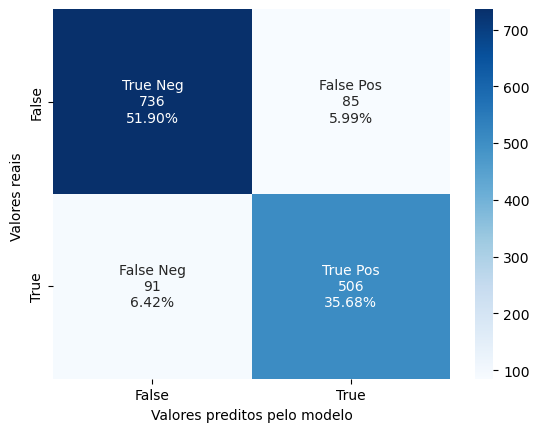

In [ ]:
y_pred = classifier.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('Valores preditos pelo modelo')
ax.set_ylabel('Valores reais ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('my_plot.JPEG')
plt.show()